In [97]:
# Intro to how to Obtain the light curves from TESS Full Frame Images (FFI)

In [98]:
import matplotlib
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import lightkurve as lk
%matplotlib inline

In [99]:
## Search for the available dataset
search_result = lk.search_tesscut('TIC 356473034')
# You can specify the search for certain sector, sector=20)
# search_result = lk.search_tesscut('TIC 356473034', sector=20)
print(search_result)

SearchResult containing 2 data products.

 #     mission     year  author exptime  target_name  distance
                                   s                   arcsec 
--- -------------- ---- ------- ------- ------------- --------
  0 TESS Sector 20 2019 TESScut    1426 TIC 356473034      0.0
  1 TESS Sector 47 2021 TESScut     475 TIC 356473034      0.0


C:\Users\Mohamed Ismaiel\anaconda3\lib\site-packages\lightkurve\search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<AxesSubplot:title={'center':'Target ID: TIC 356473034, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

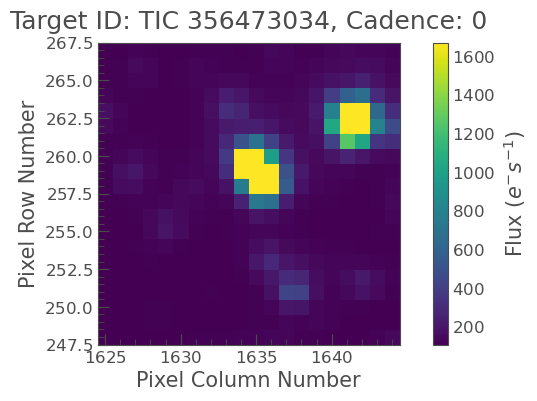

In [100]:
## Get part of the image which we interested in
tpf = search_result.download(cutout_size=20)
#To dounload all dataset search_result.download_all
tpf.plot()

In [101]:
## Count number of pixels that pass a certian detection threshold in the image 
# if there is something interesting
target_mask = tpf.create_threshold_mask(threshold=25, reference_pixel='center')
n_target_pixels = target_mask.sum()
print(f'Pixels above threshold = {n_target_pixels}')

Pixels above threshold = 12


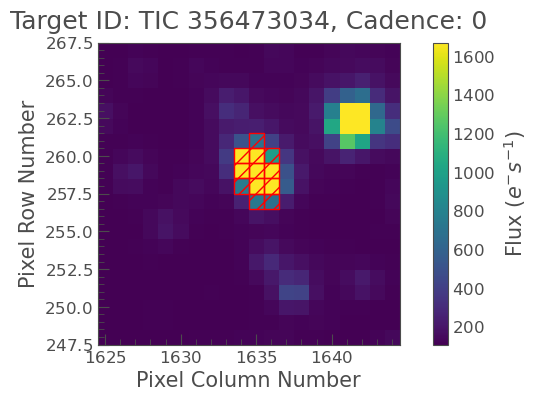

In [102]:
## Create a mask on the pixels above the threshold (To extract the signal)
tpf.plot(aperture_mask=target_mask, mask_color='r');

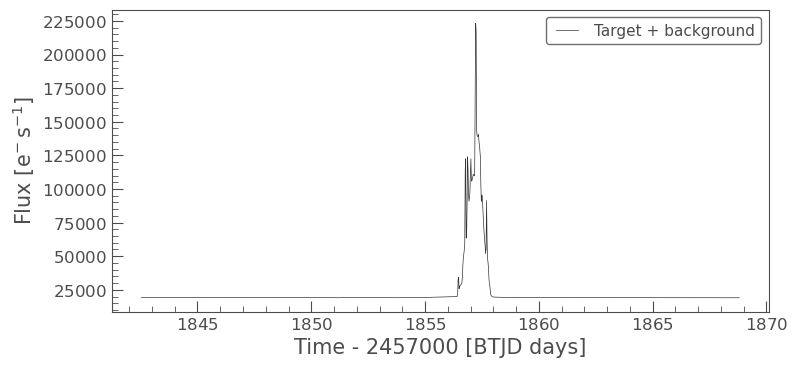

In [103]:
## The extracted flux from the masked image
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)
target_lc.plot(label='Target + background');

In [104]:
## An interactive view of the downloaded images
tpf.interact_sky()

Pixels of Bkg = 200


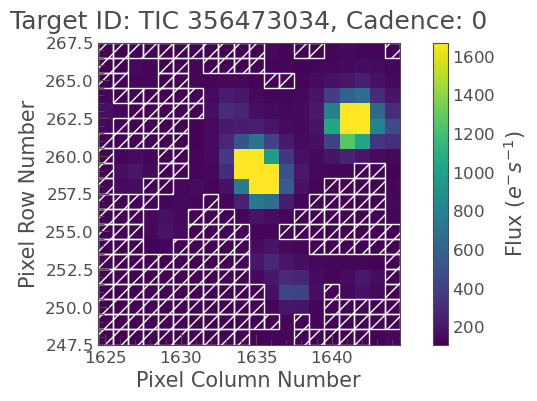

In [105]:
## To estimate the background, create a background mask
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
tpf.plot(aperture_mask=background_mask, mask_color='w');

n_background_pixels = background_mask.sum()
print(f'Pixels of Bkg = {n_background_pixels}')

In [106]:
#Calculate the bkg intensity per pixel
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels

In [107]:
#proget the bkg intensity on target pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels

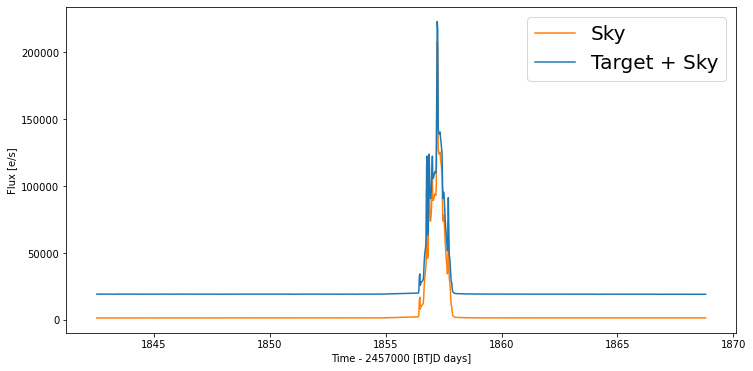

In [108]:
# intensity vs Time
plt.figure(figsize=(12,6))
plt.plot(background_estimate_lc.time.btjd, background_estimate_lc.flux, c='C1', label='Sky')
plt.plot(target_lc.time.btjd, target_lc.flux, c='C0', label='Target + Sky')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Flux [e/s]')
plt.legend(fontsize=20)
plt.show()


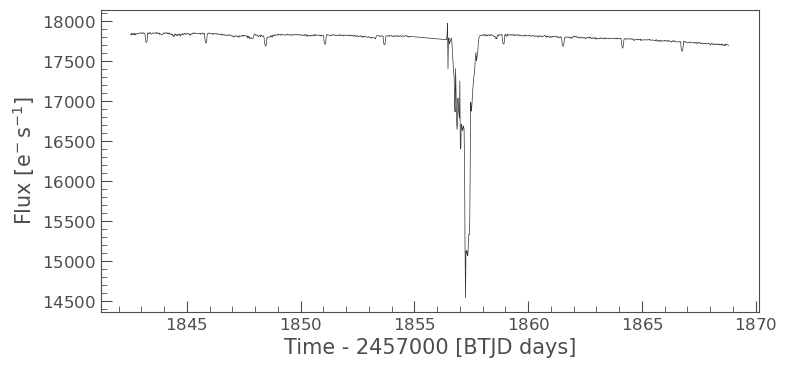

In [109]:
# subtract from the background
corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot();

Text(0, 0.5, 'Normalized Flux')

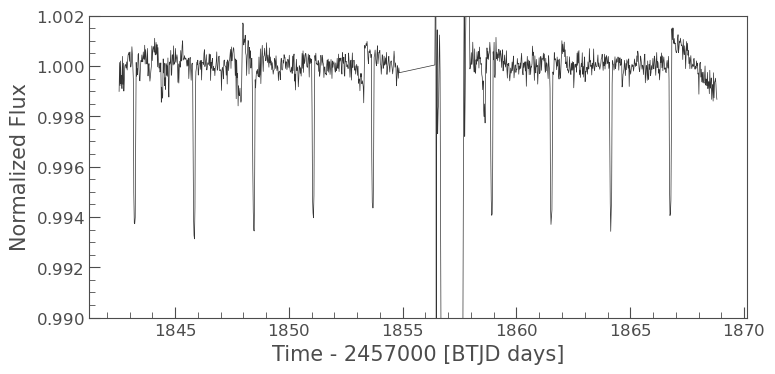

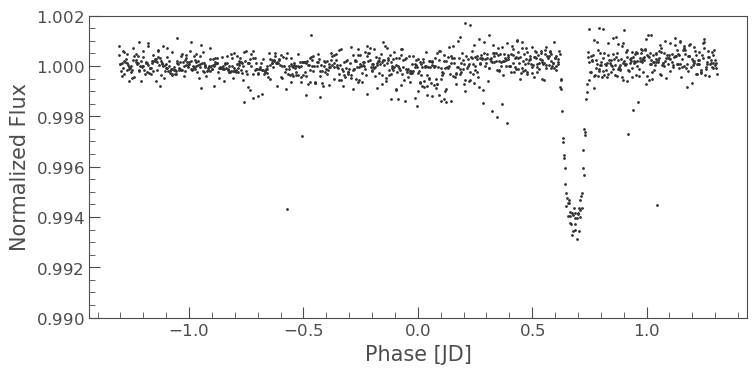

In [110]:

# Plot the Flatten light curve (each dip = a transit)
corrected_lc.flatten().plot()
plt.ylim(0.990 , 1.002)
plt.ylabel('Normalized Flux')

# Fold the light curve using the planet period to form one light curve
corrected_lc.flatten().fold(2.61586178).scatter()
plt.ylim(0.990 , 1.002)
plt.ylabel('Normalized Flux')


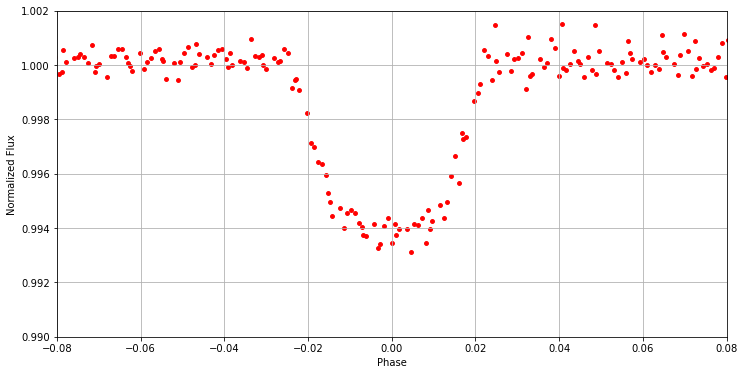

In [111]:
#Correct the phase and plot the final light kurve
plt.figure(figsize=(12,6))
period = 2.61586178
time_of_transit = 2454508.73829
lc_corr = corrected_lc.flatten()
phase = ((lc_corr.time.btjd + 2457000 - time_of_transit + period/2) % period - period/2) / period
plt.scatter(phase, lc_corr.flux, s=15, color='r')
plt.xlim(-0.08, 0.08)
plt.ylim(0.990, 1.002)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.grid()
plt.show()


In [113]:
# Save the Data

time = corrected_lc.flatten().time.btjd
flux = corrected_lc.flatten().flux
fileout = open('Data_Files/XO-2N_FFI.dat', 'w') 
for t, f in zip(time, flux):
    fileout.write('{0:13.7f} {1:14f}\n'.format(t, f))
fileout.close()
